# Data Preparation

In [ ]:
from typing import List, Any


def convert_feature(data_name: Any, codex: List[Any]) -> int: 
    """
    Given a data point in its raw form (i.e., the name of the data), 
    return the coded integer for HMM analysis 
    (i.e., the index of the data_name in the codex list). 
    
    Note: codex should be the data_type list above. 
    """
    return codex.index(str(data_name))


"""
Retrieve all raw (sequential) data. 
In most cases, this will be multiple sequences of data in similar format. 
Although not required, it is recommended to first store them in a dictionary. 
"""
data = {}  # Dict[key: List[sequential_data]]

# Load your dataset to the data dictionary 
# WRITE YOUR CODE HERE # 

"""
Obtain all distinct data types in data. 
Then, convert any forms of data first to string and 
then to standardized integer values for the HMM analysis 
"""
data_type = [] 
for value in data.values(): 
    data_type.extend(str(val) for val in value if str(val) not in data_type)

# Convert each the raw data from its original form to integers for analysis 
for key, item in data.items(): 
    temp = [convert_feature(d, data_type) for d in item]
    data[key] = temp


In [ ]:
import numpy as np 

"""
Prepare the data in the format that hmmlearn requires: 
all sequences of data should be stored in one single array, named V; 
the lengths of each sequence of data should be stored in another array, named lengths. 

"""

V = []  # the data in sequence 
lengths = []  # the length of each sequence in V

for values in data.values(): 
    V.extend(values)
    lengths.append(len(values))

# Reshape V and lengths to be the format required by the HMM analysis 
V = np.reshape(np.array(V), (len(V), -1)) 
lengths = np.reshape(np.array(lengths), (len(lengths), -1))


# Analysis 

In [ ]:
# Install the hmmlearn package if it's not installed already 
!pip install hmmlearn 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
from hmmlearn import hmm 


def calculate_BIC(k: int, X: np.ndarray, logLikelihood: float) -> float:
    """
    Determining the best model by comparing the BIC of models. 
    The optimized model should provide good-enough performance, 
    but without unnecessary increase in complexity. 
    * BIC = Baysian Information Criterion 
    
    k: Number of parameters in the model. 
       I.e., the parameter that we are trying to optimize.
    X: Data that have been fitted upon.
    loglikelihood: Log-likelihood of the model's performance 
    """
    return np.log(len(X)) * k - 2 * logLikelihood


def optimize_hidden_states(max_n: int, V: np.ndarray, lengths: np.ndarray, 
                           iterations=20) -> None: 
    """
    Plot the log-likelihood versus the number of hidden states used for the HMM 
    Recommend using the model with the lowest BIC for analysis and results 

    max_n: the maximum number of hidden states = len(data_type)
    V: the sequential data 
    lengths: the length of each data sequence in V 
    iterations: the number of iterations that the HMM analysis should perform 
    """
    log_like = []  # log likelihood 
    bic = []  # Bayesian Information Criterion 

    # Run the HMM model with different number of hidden states 
    for i in range(max_n): 
        n_states = i + 1
        model = hmm.MultinomialHMM(n_components=n_states, n_iter=iterations)
        model.fit(V, lengths)
        log_like.append(model.score(V, lengths))
        k = n_states * n_states * (n_states - 1) + (n_states - 1) + (n_states) * (model.n_features)
        bic.append(calculate_BIC(k, V, log_like[-1]))

    # Choose the best model with the smallest BIC 
    best_n_states = bic.index(min(bic))
    print("The best model should have " + str(best_n_states + 1) + " hidden states.")
    print("The best model has log-likelihood:", log_like[best_n_states])

    # Plot out the log-likelihood and the BIC 
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(np.arange(1, len(log_like) + 1), log_like)
    axs[0].set_xlabel("Number of Hidden States")
    axs[0].set_ylabel("Log-Likelihood")
    axs[1].plot(np.arange(1, len(bic) + 1), bic)
    axs[1].set_xlabel("Number of Hidden States")
    axs[1].set_ylabel("BIC")
    plt.tight_layout() 
    plt.show() 


def hmm_analysis(n_states: int, V: np.ndarray, lengths: np.ndarray, 
                 iterations=20) -> hmm.MultinomialHMM: 
    """
    Use the best number of states, as determined using the optimize_hidden_states() above, 
    to perform detailed analysis with the HMM 

    n_states: the (optimized) number of hidden states as found above 
    V: the sequential data 
    lengths: the length of each data sequence in V 
    iterations: number of iterations (recommend starting with ~20)
    """
    # Run the hmm model 
    model = hmm.MultinomialHMM(n_components=n_states, n_iter=iterations)
    model.fit(V, lengths)

    print(f'Transition Matrix: \n{model.transmat_}\n')
    print(f'Emission Matrix: \n{model.emissionprob_}\n')
    print(f'Initial Probabilities: \n{model.startprob_}\n')
    print("Log likelihood:", model.score(V, lengths))
    return model 


def plot_hmm(model: hmm.MultinomialHMM, n_states: int, data_type: List[Any]) -> None: 
    """
    Plot the optimized HMM analysis results in heatmaps 

    model: the optimized HMM model 
    n_states: the number of hidden states used in the model 
    data_type: an array of all the data types in the dataset
    """
    transmat = model.transmat_
    emissionprob = model.emissionprob_

    sns.set(rc={'figure.figsize': (30, 5)})
    fig, (ax1, ax2) = plt.subplots(1, 2)

    sns.heatmap(transmat, annot=True, linewidths=1, vmin = 0, vmax = 1, 
                annot_kws={"fontsize":10}, cbar=False, ax=ax1, square=True, 
                cmap="hot")
    sns.heatmap(emissionprob, annot=True, linewidths=1, vmin = 0, vmax = 1, 
                annot_kws={"fontsize":10}, cbar=True, 
                cbar_kws={'label': 'Probability'}, ax=ax2, cmap="hot") 

    ax1.set_ylabel("Last State", fontsize=13)
    ax1.set_xlabel("Next State", fontsize=13)
    ax1.set_xticklabels(range(1, n_states + 1))
    ax1.set_yticklabels(range(1, n_states + 1))
    ax1.yaxis.tick_left()
    ax1.xaxis.tick_top()
    ax1.tick_params(length=3)
    ax1.xaxis.set_label_position('top')

    ax2.set_ylabel("State", fontsize=15)
    ax2.set_yticklabels(range(1, n_states + 1))
    ax2.tick_params(length=3)
    ax2.yaxis.tick_left()
    ax2.xaxis.tick_bottom()
    ax2.set_xticklabels(data_type, rotation=90)

    fig.tight_layout()
    plt.show()
    

The best model should have 3 hidden states.
The best model has log-likelihood: -321.64312779981594


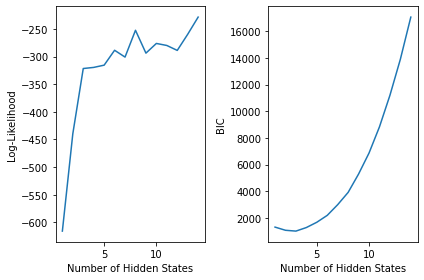

In [ ]:
"""
Find the optimum number of hidden states for the dataset. 
Goal: use a model that provides relatively good-enough performance, 
      but avoid overfitting the dataset with too much parameters 
"""
np.random.seed(80)
optimize_hidden_states(len(data_type), V, lengths)

Transition Matrix 
[[8.47361032e-03 1.36881684e-11 9.91526390e-01]
 [4.37941981e-02 9.56205802e-01 9.96217945e-17]
 [6.78321369e-01 1.18879392e-01 2.02799239e-01]]

Emission Matrix 
[[9.99999805e-01 1.95087631e-07 0.00000000e+00 1.55592128e-26
  3.22030482e-14 1.95126069e-49 1.85305794e-25 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.61356143e-49]
 [6.75676745e-03 1.01829004e-13 0.00000000e+00 3.55832526e-27
  7.09459009e-01 9.45947413e-02 1.82432715e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.75676724e-03]
 [1.00806238e-06 9.04107241e-01 0.00000000e+00 9.58901786e-02
  1.57254090e-06 3.22461859e-14 2.07423213e-60 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.11251236e-70]]

Initial Probabilities 
[1.00000000e+00 3.23729920e-28 7.10956681e-22]

Log likelihood -321.64341945590644


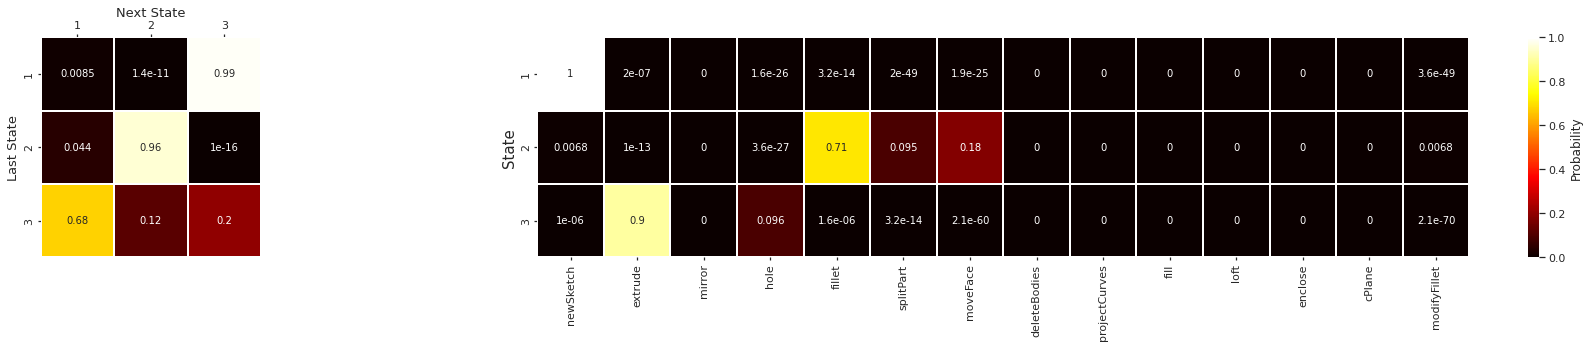

In [ ]:
"""
use the optimum number of hidden states found above to conduct actual HMM 
analysis and print/plot out the results 
"""
np.random.seed(80)
num_hidden_states = 3  # Change according to results shown above 

model = hmm_analysis(num_hidden_states, V, lengths)
plot_hmm(model, num_hidden_states, data_type)